
# House Price Prediction: Final Pipeline & Export

---

## Overview
This notebook covers the final prediction pipeline, visualization, and export of results for the House Price Prediction project.

---

## Table of Contents
1. Load Best Model & Columns
2. Load Test Data
3. Preprocess Test Data
4. Predict & Visualize Results
5. Export Predictions
6. Summary


---

## 1. Load Best Model & Columns
Load the best trained model and the columns used during training.

In [13]:
import pandas as pd
import numpy as np
import joblib
import os

# Load model and columns
model = joblib.load('../models/model_house_price_prediction.pkl')
model_columns = joblib.load('../models/model_columns.pkl')


## 2. Load Test Data
Load the test data for final predictions.

In [14]:
test_df = pd.read_csv('../data/test.csv')
test_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.00,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.00,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.00,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.00,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.00,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


## 3. Preprocess Test Data
Applying the same feature engineering and preprocessing as training.

In [15]:
# Set float format to avoid overflow
pd.options.display.float_format = '{:.2f}'.format

# Feature Engineering
test_df['TotalSF'] = test_df['TotalBsmtSF'] + test_df['1stFlrSF'] + test_df['2ndFlrSF']
test_df['HouseAge'] = test_df['YrSold'] - test_df['YearBuilt']
test_df['RemodAge'] = test_df['YrSold'] - test_df['YearRemodAdd']

# One-hot Encoding
cat_cols = test_df.select_dtypes(include='object').columns
test_encoded = pd.get_dummies(test_df, columns=cat_cols, drop_first=True)

# Align with Training Columns
for col in model_columns:
    if col not in test_encoded.columns:
        test_encoded[col] = 0
test_encoded = test_encoded[model_columns]

# Skewness Correction
skewed_feats = test_encoded.select_dtypes(include=[np.number]).apply(lambda x: x.skew()).sort_values(ascending=False)
skewed_cols = skewed_feats[abs(skewed_feats) > 0.75].index.tolist()

# Apply log1p if values >= 0 and not binary
for col in skewed_cols:
    if test_encoded[col].nunique() > 2 and (test_encoded[col] >= 0).all():
        if test_encoded[col].max() < 1e18:  # Safety check
            test_encoded[col] = np.log1p(test_encoded[col])

# Handle Missing Values
for col in test_encoded.columns:
    if test_encoded[col].dtype == 'object':
        test_encoded[col] = test_encoded[col].fillna(test_encoded[col].mode()[0])
    else:
        test_encoded[col] = test_encoded[col].fillna(test_encoded[col].median())

test_encoded.head()


,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1461,3.04,80.00,9.36,5,6,1961,1961,0.00,468.00,...,False,False,False,False,True,False,False,False,True,False
1,1462,3.04,81.00,9.57,6,6,1958,1958,108.00,923.00,...,False,False,False,False,True,False,False,False,True,False
2,1463,4.11,74.00,9.53,5,5,1997,1998,0.00,791.00,...,False,False,False,False,True,False,False,False,True,False
3,1464,4.11,78.00,9.21,6,6,1998,1998,20.00,602.00,...,False,False,False,False,True,False,False,False,True,False
4,1465,4.80,43.00,8.52,8,5,1992,1992,0.00,263.00,...,False,False,False,False,True,False,False,False,True,False


## 4. Predict & Visualize Results
Make predictions and visualize the results.

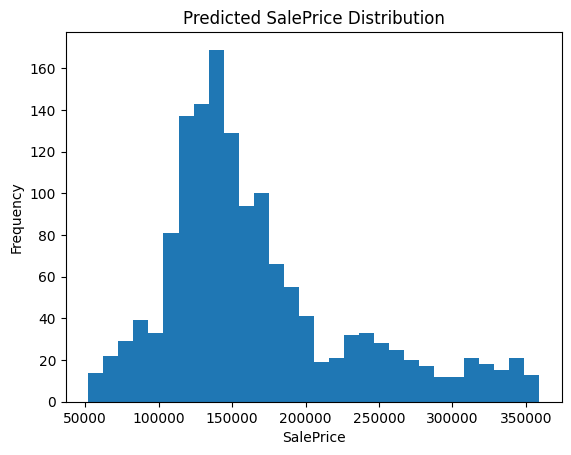

In [16]:
preds = model.predict(test_encoded)

import matplotlib.pyplot as plt
plt.hist(preds, bins=30)
plt.title('Predicted SalePrice Distribution')
plt.xlabel('SalePrice')
plt.ylabel('Frequency')
plt.show()

## 5. Export Predictions <a id='Export-Predictions'></a>
Export the predictions to a CSV file.

In [17]:
# If test_df has an 'Id' column, use it; otherwise, use the index
id_col = test_df['Id'] if 'Id' in test_df.columns else test_df.index
submission = pd.DataFrame({'Id': id_col, 'SalePrice': preds})
submission.to_csv('../output/final_predictions.csv', index=False)
print('Predictions exported to ../output/final_predictions.csv!')

Predictions exported to ../output/final_predictions.csv!


## 6. Summary <a id='Summary'></a>
- Loaded the best model and test data  
- Preprocessed test data and made predictions  
- Visualized and exported the results  

**Project Complete!**